In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import accuracy_score

import torch
from torch import nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


from data import generate_balanced_dataset, SimpleDataset
from models import MyNetwork

## Generate the dataset

Generate the dataset, make sure it is balanced.

In [11]:
dataset = generate_balanced_dataset(
            n_points = 1000,
            bounds = 2,
            n_dimension = 4,
            n_sphere_radius = 1,
            n_sphere_center = np.array([0,0,0,0]),
        )

label_ratio = sum(dataset['is_outside'] == True)/len(dataset['is_outside'])
print(f'Label ratio: {label_ratio}')

Label ratio: 0.5


## Train moldel for different encoding functions

In [17]:
def train_model(model, train_dataloader):

    criterion = nn.BCELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1000):
        for data in train_dataloader:
            
            inputs, labels = data
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.flatten(), labels)
            loss.backward()
            optimizer.step()

def test_model(model, x_valid, y_valid):
    return accuracy_score((model(x_valid)>0.5).flatten(), y_valid)

### Independent features

In [20]:
x_data = torch.tensor(dataset['x_0 x_1 x_2 x_3'.split()].values, dtype=torch.float32)
y_data = torch.tensor(dataset['is_outside'].values, dtype=torch.float32)

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.3, shuffle=True)

train_dataset = SimpleDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [23]:
no_combination_acc = []

for i in range(100):
    model = MyNetwork(combined=False)
    train_model(model, train_dataloader)
    acc = test_model(model, x_valid, y_valid)
    no_combination_acc.append(acc)
    print(f'{i}\tacc:\t{acc:.2f}', end='\r')

In [25]:
no_combination_acc_array = np.array(no_combination_acc)
print(f'mean:\t{no_combination_acc_array.mean()}')
print(f'std:\t{no_combination_acc_array.std()}')

mean:	0.9539
std:	0.01951668801592912


### Combining $\frac{1}{2}(x_j^{2} + x_k^{2}$)

In [359]:
dataset['combined_1'] = (dataset['x_0']**2 + dataset['x_1']**2)/2
dataset['combined_2'] = (dataset['x_2']**2 + dataset['x_3']**2)/2

x_data = torch.tensor(dataset[['combined_1','combined_2']].values, dtype=torch.float32)
y_data = torch.tensor(dataset['is_outside'].values, dtype=torch.float32)

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.3, shuffle=True)

train_dataset = SimpleDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [360]:
ideal_combination_acc = []

for i in range(1):
    model = MyNetwork(combined=True)
    train_model(model, train_dataloader)
    acc = test_model(model, x_valid, y_valid)
    ideal_combination_acc.append(acc)
    print(f'{i}\tacc:\t{acc:.2f}', end='\r')

In [28]:
ideal_combination_acc_array = np.array(ideal_combination_acc)
print(f'mean:\t{ideal_combination_acc_array.mean()}')
print(f'std:\t{ideal_combination_acc_array.std()}')

mean:	0.9933333333333337
std:	4.440892098500626e-16


### $g(x_j, x_k) = (x_j \cdot x_k)$

In [349]:
dataset['combined_1'] = dataset['x_0'] * dataset['x_1']
dataset['combined_2'] = dataset['x_2'] * dataset['x_3']

x_data = torch.tensor(dataset[['combined_1','combined_2']].values, dtype=torch.float32)
y_data = torch.tensor(dataset['is_outside'].values, dtype=torch.float32)

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.3, shuffle=True)

train_dataset = SimpleDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [350]:
multiply_combination_acc = []

for i in range(1):
    model = MyNetwork(combined=True)
    train_model(model, train_dataloader)
    acc = test_model(model, x_valid, y_valid)
    multiply_combination_acc.append(acc)
    print(f'{i}\tacc:\t{acc:.2f}', end='\r')

In [31]:
multiply_combination_acc_array = np.array(multiply_combination_acc)
print(f'mean:\t{multiply_combination_acc_array.mean()}')
print(f'std:\t{multiply_combination_acc_array.std()}')

mean:	0.9463333333333334
std:	0.004582575694955841


### $g(x_j, x_k) = (x_k + x_k)$

In [326]:
dataset['combined_1'] = dataset['x_0'] + dataset['x_1']
dataset['combined_2'] = dataset['x_2'] + dataset['x_3']

x_data = torch.tensor(dataset[['combined_1','combined_2']].values, dtype=torch.float32)
y_data = torch.tensor(dataset['is_outside'].values, dtype=torch.float32)

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.3, shuffle=True)

train_dataset = SimpleDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [327]:
sum_combination_acc = []

for i in range(1):
    model = MyNetwork(combined=True)
    train_model(model, train_dataloader)
    acc = test_model(model, x_valid, y_valid)
    sum_combination_acc.append(acc)
    print(f'{i}\tacc:\t{acc:.2f}', end='\r')

In [34]:
sum_combination_acc_array = np.array(sum_combination_acc)
print(f'mean:\t{sum_combination_acc_array.mean()}')
print(f'std:\t{sum_combination_acc_array.std()}')

mean:	0.8661333333333332
std:	0.007582435844326893


### $g(x_j, x_k) = (x_j + x_k)^2$

In [330]:
dataset['combined_1'] = (dataset['x_0'] + dataset['x_1'])**2
dataset['combined_2'] = (dataset['x_2'] + dataset['x_3'])**2

x_data = torch.tensor(dataset[['combined_1','combined_2']].values, dtype=torch.float32)
y_data = torch.tensor(dataset['is_outside'].values, dtype=torch.float32)

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.3, shuffle=True)

train_dataset = SimpleDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [331]:
sum_sq_combination_acc = []

for i in range(1):
    model = MyNetwork(combined=True)
    train_model(model, train_dataloader)
    acc = test_model(model, x_valid, y_valid)
    sum_sq_combination_acc.append(acc)
    print(f'{i}\tacc:\t{acc:.2f}', end='\r')

In [115]:
sum_combination_acc_array = np.array(sum_sq_combination_acc)
print(f'mean:\t{sum_combination_acc_array.mean()}')
print(f'std:\t{sum_combination_acc_array.std()}')

mean:	0.8825
std:	0.0014433756729740495


### $g(x_j, x_k) = (x_j^2 \times x_k^2)$

In [334]:
dataset['combined_1'] = (dataset['x_0']**2) * (dataset['x_1']**2)
dataset['combined_2'] = (dataset['x_2']**2) * (dataset['x_3']**2)

x_data = torch.tensor(dataset[['combined_1','combined_2']].values, dtype=torch.float32)
y_data = torch.tensor(dataset['is_outside'].values, dtype=torch.float32)

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.3, shuffle=True)

train_dataset = SimpleDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [335]:
multiply_sq_combination_acc = []

for i in range(1):
    model = MyNetwork(combined=True)
    train_model(model, train_dataloader)
    acc = test_model(model, x_valid, y_valid)
    multiply_sq_combination_acc.append(acc)
    print(f'{i}\tacc:\t{acc:.2f}', end='\r')

In [114]:
multiply_sq_combination_acc = np.array(multiply_sq_combination_acc)
print(f'mean:\t{multiply_sq_combination_acc.mean()}')
print(f'std:\t{multiply_sq_combination_acc.std()}')

mean:	0.9587666666666665
std:	0.003321813427097383


### Plot

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# These values come from running the cells above.

no_comb_mean = 0.954
no_comb_std = 0.020

ideal_mean = 0.993
ideal_std = 0.0

sum_mean = 0.87
sum_std = 0.008

sum_sq_mean = 0.8825
sum_sq_std = 0.001

multiply_mean = 0.95
multiply_std = 0.005
mult_sq_mean = 0.96
mult_sq_std = 0.003

In [14]:
palette = plt.get_cmap('tab20').colors

colors = [
    palette[0],
    palette[1],
    palette[2],
    palette[3],
    palette[4],
    palette[6]
]

In [15]:
means = np.array([
    sum_mean,
    sum_sq_mean,
    multiply_mean,
    mult_sq_mean,
    ideal_mean,
    no_comb_mean
])

error = np.array([
    sum_std,
    sum_sq_std,
    multiply_std,
    mult_sq_std,
    ideal_std,
    no_comb_std
])

techniques = [
    '$(x_j + x_k)$',
    '$(x_j + x_k)^2$',
    '$(x_j \\times x_k)$',
    '$(x_j \\times x_k)^2$',
    '$\\frac{1}{2} ( x_j^2 + x_k^2) $',
    'Independent',
    ]

x_pos = np.arange(len(techniques))

Text(0.5, 0, 'Accuracy [%]')

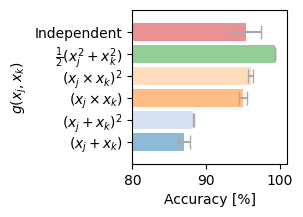

In [16]:
fig, ax = plt.subplots(figsize=(2,2))
ax.barh(
    x_pos,
    100*means,
    xerr=100*error,
    align='center',
    alpha=0.5,
    ecolor='darkgrey',
    color=colors,
    capsize=5
)

ax.set_yticks(x_pos)
ax.set_yticklabels(techniques, rotation = 0)

ax.set_xbound(80,101)
ax.set_ybound(-1,6)

ax.set_ylabel("$g(x_j, x_k)$")
ax.set_xlabel("Accuracy [%]")